# Phi-2 Psychophysics

## Numeric Sample Discrimination

### Overview
This notebook provides an implementation of a "textual-psychophysics" experiment designed to evaluate the decision-making capabilities of the **Phi-2** language model in distinguishing between two predefined distributions, known as Distribution "A" and Distribution "B". The model learns about these distributions solely through exposure to limited samples from each. This experiment draws inspiration from psychophysics paradigms used in neuroscience to assess decision-making, evidence accumulation, and biases in probabilistic classification.

### Procedure
**Initial Sampling**: The experiment begins by instructing the model about the task and providing several samples from both Distribution "A" and Distribution "B". This step allows the language model to form an internal representation of each distribution’s characteristics.  

**Testing on New Sample**: After the initial sampling, a new stimulus sample is presented to the model. The model must classify it as belonging to Distribution "A" or "B" based on its prior exposure. The model is constrained to output only "A" or "B" without additional reasoning, ensuring a controlled decision-making process.

**Response Collection and Analysis**: The model’s classifications are collected across multiple trials, and response fractions are computed for different stimulus values. Standard error calculations account for binomial proportion variability, allowing for statistical analysis of the model’s classification behavior.

### Technical Details
The model used for this experiment is **Phi-2 (2.7B parameters)**, running on a GPU (if available) with **FP16 precision** for efficiency. The experiment is implemented in Python and leverages PyTorch for model inference. The model operates in evaluation mode, and GPU memory is managed to optimize performance.

In [36]:
# --------- Import Libraries ---------

import numpy as np
import torch
import re
import textwrap
from collections import Counter
import matplotlib.pyplot as plt
from datasets import Dataset
import tqdm
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteria, StoppingCriteriaList


In [37]:
# --------- Setup GPU and Load Model ---------

# Check CUDA availability and set device
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())
print("Torch cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    print("Total CUDA memory: {} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("CUDA memory allocated: {} GB".format(torch.cuda.memory_allocated(0) / 1e9))
    print("CUDA memory reserved: {} GB".format(torch.cuda.memory_reserved(0) / 1e9))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device name --->", device)

# Clear GPU memory before loading the model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU memory cleared.")

# Use Phi-2 model (2.7B parameters)
model_id = "microsoft/phi-2"
config_data = json.load(open("config.json"))
HF_TOKEN = config_data["HF_TOKEN"]  # Note: Phi-2 is public, but you can still use HF_TOKEN if needed

# Load tokenizer and model (no quantization needed, FP16 for 2.7B)
print("Downloading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # Ensure pad token is set

print("Downloading model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0" if torch.cuda.is_available() else "cpu",  # Force GPU if available
    torch_dtype=torch.float16,  # Use FP16 for efficiency on 8.5GB GPU
    trust_remote_code=True
)
model.eval()  # Set to evaluation mode

# Verify device placement
print("Model loaded successfully!")
print("Model device mapping:", model.device)

# Suppress resume_download warning (optional, can be ignored)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")

# --------- Helper Functions ---------

class ABStoppingCriteria(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        decoded_so_far = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return "##OUTPUT\nA" in decoded_so_far or "##OUTPUT\nB" in decoded_so_far

def prepare_prompt(samples_A, samples_B, current_sample):
    system_message = (
        "You are the subject of a psychophysics experiment."
        "You have to determine whether a new stimulus sample belongs to Distribution A or B.\n"
        "Distribution A yieled these samples:"
        f"{' '.join(map(str, np.round(samples_A, 2)))}.\n"
        "Distribution B yieled these samples:"
        f"{' '.join(map(str, np.round(samples_B, 2)))}.\n\n"
        "Compare the new sample's value and classify it correctly.\n"
        "Respond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\n"
        "Do NOT include any explanations, reasoning, or extra text."
    )

    user_message = f"New stimulus sample: {np.round(current_sample, 2)}.\n\n##OUTPUT\n"

    return system_message + "\n" + user_message

def compute_fractions(responses):
    counts = Counter(responses)
    total = len(responses)
    fraction_a = counts.get('A', 0) / total
    fraction_b = counts.get('B', 0) / total
    return [fraction_a, fraction_b]

def clean_response(text):
    matches = re.findall(r"##OUTPUT\s*\n\s*(A|B)", text, re.IGNORECASE)
    return matches[-1] if matches else "Invalid"

def generate_responses_with_dataset(prompts, batch_size=5, max_tokens=2, sampling=True, output_raw=False):
    dataset = Dataset.from_dict({"text": prompts})
    batched_prompts = dataset["text"]
    inputs = tokenizer(
        batched_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    stopping_criteria = StoppingCriteriaList([ABStoppingCriteria()]) if max_tokens <= 2 else None

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            do_sample=sampling,  # Enable sampling to explore alternatives
            temperature=0.7 if sampling else 1.0,  # Controlled sampling or greedy decoding
            top_p=0.9 if sampling else 1.0,        # Nucleus sampling or full distribution
            max_new_tokens=max_tokens,             # Limit for brevity or conversation
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            stopping_criteria=stopping_criteria
        )

    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    print("Raw Model Outputs:", decoded_outputs)  # Debugging

    # Handle classification or conversational output
    cleaned_responses = []
    for output in decoded_outputs:
        if output_raw or max_tokens > 2:  # Return raw output for conversation or if requested
            cleaned_responses.append(output.strip())
        else:  # Classification task, clean to 'A' or 'B'
            cleaned_responses.append(clean_response(output))

    return cleaned_responses

# --------- Quick Test of Classification Task ---------

# Define Gaussian distributions for sample generation
dist_a = {'mean': 1, 'std': 0.25}
dist_b = {'mean': 8, 'std': 0.25}

# Generate 5 samples from each distribution
samples_A = np.round(np.random.normal(dist_a['mean'], dist_a['std'], 5), 2)
samples_B = np.round(np.random.normal(dist_b['mean'], dist_b['std'], 5), 2)
test_sample = dist_b['mean']+0.5  # Example stimulus

# Prepare test prompt
test_prompt = prepare_prompt(samples_A, samples_B, test_sample)

# Generate a small test response for classification
output = generate_responses_with_dataset([test_prompt], batch_size=1, max_tokens=2, sampling=True)

# Print model output for debugging
print("\n--- Classification Test ---")
print("Prompt:", test_prompt)
print("Raw Model Outputs:", output)
print("Clean Model Output:", output)

PyTorch version: 2.3.0+cu118
CUDA version: 11.8
cuDNN version: 8700
CUDA available: True
Torch cuda version: 11.8
Total CUDA memory: 8.585281536 GB
CUDA memory allocated: 6.343702016 GB
CUDA memory reserved: 11.809062912 GB
Device name ---> cuda:0
GPU memory cleared.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Model loaded successfully!
Model device mapping: cuda:0
Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.19 0.77 1.22 1.34 1.1.\nDistribution B yieled these samples:8.47 7.81 7.69 7.56 8.37.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 8.5.\n\n##OUTPUT\nA"]

--- Classification Test ---
Prompt: You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.
Distribution A yieled these samples:1.19 0.77 1.22 1.34 1.1.
Distribution B yieled these samples:8.47 7.81 7.69 7.56 8.37.

Compare the new sample's value and classify it correctly.
Respond ONLY with '##OUTPUT
A' or '##OUTPUT
B'.
Do NOT include any explanations, reasoning, or 

In [38]:
# --------- Main Experiment Loop ---------

# Experiment Parameters
dist_a = {'mean': 1, 'std': 0.25}
dist_b = {'mean': 3, 'std': 0.25}

testing_samples = np.arange(0.0, 4.0, 0.25)
n_batches = 25
n_samples = 5
response_fractions = []

# Main Experiment Loop
for sample in tqdm.tqdm(testing_samples, desc="Testing samples"):
    # Generate a different set of samples for each batch
    batched_prompts = []
    for _ in range(n_batches):
        samples_a = np.round(np.random.normal(dist_a['mean'], dist_a['std'], n_samples), 2)
        samples_b = np.round(np.random.normal(dist_b['mean'], dist_b['std'], n_samples), 2)
        batched_prompts.append(prepare_prompt(samples_a, samples_b, sample))

    # Generate responses for all batched prompts
    responses = generate_responses_with_dataset(batched_prompts, batch_size=5, max_tokens=2)

    # Print a subset of responses
    num_to_print = min(10, len(responses))
    print(f"Stimulus {sample}: First {num_to_print} Model Responses:")
    for i in range(num_to_print):
        print(f"  Response {i+1}: {responses[i]}")

    # Compute response fractions
    response_counts = Counter(responses)
    total_responses = len(responses)
    fraction_A = response_counts.get('A', 0) / total_responses
    fraction_B = response_counts.get('B', 0) / total_responses

    response_fractions.append([fraction_A, fraction_B])

# Display Results
for idx, fractions in enumerate(response_fractions):
    print(f"Stimulus {testing_samples[idx]:.2f}: A: {fractions[0]:.2f}, B: {fractions[1]:.2f}")

Testing samples:   6%|▋         | 1/16 [00:52<13:03, 52.26s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.16 0.99 1.07 0.72 1.61.\nDistribution B yieled these samples:3.03 3.03 3.18 3.12 3.06.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.0.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.8 1.12 1.47 1.34 1.4.\nDistribution B yieled these samples:2.87 2.75 2.97 3.01 3.27.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.0.\n\n##OUTPUT\nA", "You are the subject of a ps

Testing samples:  12%|█▎        | 2/16 [01:44<12:11, 52.23s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.05 0.62 1.39 1.45 0.85.\nDistribution B yieled these samples:2.9 3.07 3.08 3.16 3.5.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.25.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.96 0.8 0.66 0.82 0.99.\nDistribution B yieled these samples:3.45 2.87 3.06 3.0 3.3.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.25.\n\n##OUTPUT\nA", "You are the subject of a psy

Testing samples:  19%|█▉        | 3/16 [02:36<11:19, 52.28s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.95 1.05 1.22 1.12 1.04.\nDistribution B yieled these samples:3.09 3.6 2.99 3.05 3.26.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.5.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.28 1.3 1.16 0.71 1.41.\nDistribution B yieled these samples:2.71 3.08 2.81 2.98 3.08.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.5.\n\n##OUTPUT\nB", "You are the subject of a ps

Testing samples:  25%|██▌       | 4/16 [03:28<10:26, 52.24s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.0 1.14 1.03 0.76 1.3.\nDistribution B yieled these samples:2.96 2.99 2.77 2.89 2.78.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.75.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.96 1.43 0.66 0.6 1.37.\nDistribution B yieled these samples:2.95 2.83 3.26 2.85 3.46.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 0.75.\n\n##OUTPUT\nA", "You are the subject of a p

Testing samples:  31%|███▏      | 5/16 [04:21<09:34, 52.20s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.93 0.61 1.22 0.98 0.95.\nDistribution B yieled these samples:3.8 3.07 2.81 2.89 3.29.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.0.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.03 0.64 1.23 0.83 1.47.\nDistribution B yieled these samples:3.27 2.89 3.32 3.02 3.21.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.0.\n\n##OUTPUT\nB", "You are the subject of a p

Testing samples:  38%|███▊      | 6/16 [05:13<08:41, 52.18s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.97 1.2 1.2 0.56 1.33.\nDistribution B yieled these samples:2.58 3.26 3.28 2.73 2.9.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.25.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.72 0.95 0.92 1.19 1.33.\nDistribution B yieled these samples:3.35 2.86 2.95 2.58 2.8.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.25.\n\n##OUTPUT\nA", "You are the subject of a ps

Testing samples:  44%|████▍     | 7/16 [06:05<07:49, 52.18s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.86 0.96 1.01 0.75 1.19.\nDistribution B yieled these samples:2.87 2.94 2.75 2.36 2.95.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.5.\n\n##OUTPUT\nB", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.6 1.2 1.0 0.93 1.01.\nDistribution B yieled these samples:3.14 2.7 3.28 3.18 3.18.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.5.\n\n##OUTPUT\nA", "You are the subject of a psyc

Testing samples:  50%|█████     | 8/16 [06:57<06:57, 52.18s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.74 0.66 0.62 1.28 0.84.\nDistribution B yieled these samples:3.38 2.87 2.57 2.72 3.31.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.75.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.96 0.86 1.04 1.13 1.28.\nDistribution B yieled these samples:3.36 2.91 2.67 2.9 3.07.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 1.75.\n\n##OUTPUT\nB", "You are the subject of a

Testing samples:  56%|█████▋    | 9/16 [07:49<06:05, 52.18s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.16 0.72 0.95 1.0 1.15.\nDistribution B yieled these samples:3.17 2.82 3.02 3.11 3.36.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.0.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.18 1.2 1.02 1.35 1.1.\nDistribution B yieled these samples:2.78 3.35 3.17 2.89 2.88.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.0.\n\n##OUTPUT\nA", "You are the subject of a psy

Testing samples:  62%|██████▎   | 10/16 [08:41<05:13, 52.18s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.87 1.12 0.72 1.17 1.1.\nDistribution B yieled these samples:2.92 2.79 2.78 3.13 3.31.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.25.\n\n##OUTPUT\nB", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.84 1.11 0.48 0.85 0.99.\nDistribution B yieled these samples:2.77 2.77 2.83 3.07 2.95.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.25.\n\n##OUTPUT\nB", "You are the subject of a

Testing samples:  69%|██████▉   | 11/16 [09:34<04:21, 52.22s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.71 0.93 0.92 0.7 1.1.\nDistribution B yieled these samples:3.06 2.95 2.81 3.26 3.41.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.5.\n\n##OUTPUT\nB", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.88 0.85 1.12 0.91 0.97.\nDistribution B yieled these samples:3.18 2.52 3.33 3.02 2.9.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.5.\n\n##OUTPUT\nB", "You are the subject of a psy

Testing samples:  75%|███████▌  | 12/16 [10:26<03:28, 52.22s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.71 0.58 0.55 0.66 0.82.\nDistribution B yieled these samples:3.49 2.87 3.04 3.1 3.03.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.75.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.98 0.7 1.36 1.45 0.58.\nDistribution B yieled these samples:2.74 2.93 2.76 3.13 2.82.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 2.75.\n\n##OUTPUT\nB", "You are the subject of a 

Testing samples:  81%|████████▏ | 13/16 [11:18<02:36, 52.23s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.01 1.03 0.96 1.1 1.17.\nDistribution B yieled these samples:3.18 2.75 2.93 3.3 3.22.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.0.\n\n##OUTPUT\nB", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.66 1.09 0.51 1.01 1.47.\nDistribution B yieled these samples:2.76 2.79 3.19 2.61 2.84.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.0.\n\n##OUTPUT\nA", "You are the subject of a ps

Testing samples:  88%|████████▊ | 14/16 [12:10<01:44, 52.23s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.89 0.8 1.0 0.95 0.91.\nDistribution B yieled these samples:2.82 3.08 3.41 3.03 3.25.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.25.\n\n##OUTPUT\nB", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.65 1.04 0.73 0.63 0.82.\nDistribution B yieled these samples:3.3 3.24 3.06 2.62 2.95.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.25.\n\n##OUTPUT\nB", "You are the subject of a p

Testing samples:  94%|█████████▍| 15/16 [13:03<00:52, 52.30s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.29 0.81 1.39 0.62 1.41.\nDistribution B yieled these samples:2.91 2.94 2.53 2.89 2.74.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.5.\n\n##OUTPUT\nA", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.85 0.97 1.24 1.05 1.08.\nDistribution B yieled these samples:2.73 2.78 3.45 2.82 3.41.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.5.\n\n##OUTPUT\nB", "You are the subject of a 

Testing samples: 100%|██████████| 16/16 [13:56<00:00, 52.26s/it]

Raw Model Outputs: ["You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:1.08 0.79 1.07 1.3 0.85.\nDistribution B yieled these samples:3.52 2.87 3.01 2.83 3.06.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.75.\n\n##OUTPUT\nB", "You are the subject of a psychophysics experiment.You have to determine whether a new stimulus sample belongs to Distribution A or B.\nDistribution A yieled these samples:0.56 0.86 0.73 1.03 1.25.\nDistribution B yieled these samples:3.16 2.41 3.51 3.07 2.81.\n\nCompare the new sample's value and classify it correctly.\nRespond ONLY with '##OUTPUT\nA' or '##OUTPUT\nB'.\nDo NOT include any explanations, reasoning, or extra text.\nNew stimulus sample: 3.75.\n\n##OUTPUT\nB", "You are the subject of a

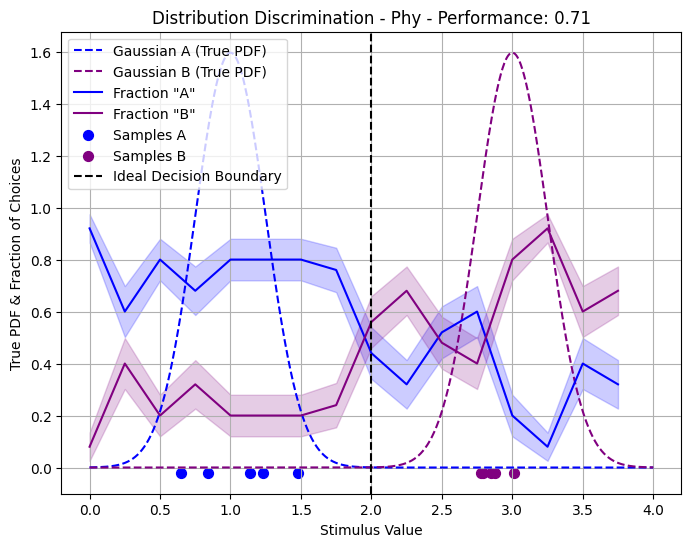

In [41]:
# --------- Plot Experiment Results ---------

# Generate x values for Gaussian curves
x = np.linspace(0, 4, 1000)
gaussian_A = (1 / (dist_a['std'] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - dist_a['mean']) / dist_a['std'])**2)
gaussian_B = (1 / (dist_b['std'] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - dist_b['mean']) / dist_b['std'])**2)

# Convert response fractions and testing samples to numpy arrays
response_fractions_matrix = np.array(response_fractions)
testing_samples_vector = np.array(testing_samples)

# Compute number of trials per stimulus
n_trials = np.full_like(testing_samples_vector, n_batches, dtype=int)  # Each stimulus has n_batches trials

# Compute standard error for binomial fractions correctly
stderr_A = np.sqrt((response_fractions_matrix[:, 0] * (1 - response_fractions_matrix[:, 0])) / n_trials)
stderr_B = np.sqrt((response_fractions_matrix[:, 1] * (1 - response_fractions_matrix[:, 1])) / n_trials)

# Create figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Gaussian distributions with dashed lines
ax1.plot(x, gaussian_A, linestyle='dashed', color='blue', label='Gaussian A (True PDF)')
ax1.plot(x, gaussian_B, linestyle='dashed', color='purple', label='Gaussian B (True PDF)')

# Plot response fractions with shaded error bars
ax1.plot(testing_samples_vector, response_fractions_matrix[:, 0], color='blue', label='Fraction "A"')
ax1.fill_between(testing_samples_vector, response_fractions_matrix[:, 0] - stderr_A, response_fractions_matrix[:, 0] + stderr_A, color='blue', alpha=0.2)
ax1.plot(testing_samples_vector, response_fractions_matrix[:, 1], color='purple', label='Fraction "B"')
ax1.fill_between(testing_samples_vector, response_fractions_matrix[:, 1] - stderr_B, response_fractions_matrix[:, 1] + stderr_B, color='purple', alpha=0.2)

# Scatter plot for samples
samples_a = np.round(np.random.normal(dist_a['mean'], dist_a['std'], 5), 2)
samples_b = np.round(np.random.normal(dist_b['mean'], dist_b['std'], 5), 2)
ax1.scatter(samples_a, np.zeros_like(samples_a) - 0.02, color='blue', s=50, label='Samples A')
ax1.scatter(samples_b, np.zeros_like(samples_b) - 0.02, color='purple', s=50, label='Samples B')

# Compute ideal decision boundary based on true distribution parameters
if dist_a['std']**2 != dist_b['std']**2:
    ideal_decision_boundary = (dist_b['std']**2 * dist_a['mean'] - dist_a['std']**2 * dist_b['mean']) / (dist_b['std']**2 - dist_a['std']**2)
else:
    # If variances are equal, the decision boundary is simply the midpoint
    ideal_decision_boundary = (dist_a['mean'] + dist_b['mean']) / 2

# Compute average performance across all samples (A before boundary, B after)
average_performance = (response_fractions_matrix[testing_samples_vector < ideal_decision_boundary, 0].mean() +
                       response_fractions_matrix[testing_samples_vector >= ideal_decision_boundary, 1].mean()) / 2

# Dashed vertical line at decision boundary
ax1.axvline(x=ideal_decision_boundary, color='black', linestyle='dashed', label="Ideal Decision Boundary")

# Set labels and title
ax1.set_xlabel('Stimulus Value')
ax1.set_ylabel('True PDF & Fraction of Choices')
ax1.set_title('Distribution Discrimination - Phy - Performance: {:.2f}'.format(average_performance))
ax1.legend(loc="upper left")

# Grid and show plot
plt.grid(True)
plt.show()



### **Ideal Observer Baseline Computation (Bayesian Decision Theory)**

The **ideal observer baseline** represents the optimal Bayesian decision-making process, assuming **perfect knowledge** of the underlying stimulus distributions. It follows directly from **Bayes' theorem** and the concept of **maximum likelihood decision-making**.

---

### **1. Gaussian Likelihoods**
We assume that the stimuli are generated from two **Gaussian distributions** corresponding to **Category A** and **Category B**:

$$
P(x | A) = \frac{1}{\sqrt{2 \pi \sigma_A^2}} \exp \left( -\frac{(x - \mu_A)^2}{2 \sigma_A^2} \right)
$$

$$
P(x | B) = \frac{1}{\sqrt{2 \pi \sigma_B^2}} \exp \left( -\frac{(x - \mu_B)^2}{2 \sigma_B^2} \right)
$$

where:
- \( \mu_A, \sigma_A^2 \) are the mean and variance of **Category A**.
- \( \mu_B, \sigma_B^2 \) are the mean and variance of **Category B**.

This assumption is common in **signal detection theory** and **psychophysical modeling**, as Gaussian distributions often describe natural variability in perception.

---

### **2. Bayes' Decision Rule**
The goal is to **classify a stimulus** \( x \) as belonging to either **Category A** or **Category B**.  
Using **Bayes' theorem**, the **posterior probability** of each category given \( x \) is:

$$
P(A | x) = \frac{P(x | A) P(A)}{P(x)}
$$

$$
P(B | x) = \frac{P(x | B) P(B)}{P(x)}
$$

where \( P(A) \) and \( P(B) \) are the prior probabilities of the two categories, and the denominator \( P(x) \) ensures proper normalization.

Since we assume **equal priors** \( P(A) = P(B) \), the decision rule simplifies to comparing the **likelihoods**:

$$
\frac{P(x | A)}{P(x | B)} \gtrless 1
$$

Taking the **logarithm** of both sides:

$$
\log P(x | A) - \log P(x | B) \gtrless 0
$$

Expanding the Gaussian likelihoods:

$$
-\frac{(x - \mu_A)^2}{2 \sigma_A^2} + \log \sigma_A \gtrless -\frac{(x - \mu_B)^2}{2 \sigma_B^2} + \log \sigma_B
$$

Solving for \( x \), we obtain the **optimal decision boundary**:

$$
x^* = \frac{\sigma_B^2 \mu_A - \sigma_A^2 \mu_B}{\sigma_B^2 - \sigma_A^2}
$$

If both distributions have the **same variance** \( \sigma_A^2 = \sigma_B^2 = \sigma^2 \), the decision boundary simplifies to:

$$
x^* = \frac{\mu_A + \mu_B}{2}
$$

which corresponds to the **midpoint** between the two means. This result makes intuitive sense: when the two categories have the same variability, the best strategy is to classify based on which mean is closer.

---

### **3. Optimal Classification Probabilities**
Rather than making a deterministic classification at the decision boundary, an **optimal Bayesian observer** assigns a probability to each category based on how likely the stimulus is under each distribution.

For any given stimulus \( x \), the probability of selecting **Category A** follows:

$$
P(A | x) = \frac{P(x | A)}{P(x | A) + P(x | B)}
$$

which is a **soft decision function** that smoothly transitions from 0 to 1 as \( x \) moves from one distribution to the other.

Similarly, the probability of selecting **Category B** is:

$$
P(B | x) = 1 - P(A | x)
$$

This formulation means that, rather than making **hard** classifications, the observer assigns confidence levels to their decision. This is particularly useful when **overlap exists between the distributions**, as it allows for **graded uncertainty** rather than forcing binary choices.

---

### **Ideal Observer Baseline Computation (Bayesian Decision Theory)**

The **ideal observer baseline** represents the optimal Bayesian decision-making process, assuming **perfect knowledge** of the underlying stimulus distributions. It follows directly from **Bayes' theorem** and the concept of **maximum likelihood decision-making**.

---

### **1. Gaussian Likelihoods**
We assume that the stimuli are generated from two **Gaussian distributions** corresponding to **Category A** and **Category B**:

$$
P(x | A) = \frac{1}{\sqrt{2 \pi \sigma_A^2}} \exp \left( -\frac{(x - \mu_A)^2}{2 \sigma_A^2} \right)
$$

$$
P(x | B) = \frac{1}{\sqrt{2 \pi \sigma_B^2}} \exp \left( -\frac{(x - \mu_B)^2}{2 \sigma_B^2} \right)
$$

where:
- $ \mu_A, \sigma_A^2 $ are the mean and variance of **Category A**.
- $ \mu_B, \sigma_B^2 $ are the mean and variance of **Category B**.

This assumption is common in **signal detection theory** and **psychophysical modeling**, as Gaussian distributions often describe natural variability in perception.

---

### **2. Bayes' Decision Rule**
The goal is to **classify a stimulus** $ x $ as belonging to either **Category A** or **Category B**.  
Using **Bayes' theorem**, the **posterior probability** of each category given $ x $ is:

$$
P(A | x) = \frac{P(x | A) P(A)}{P(x)}
$$

$$
P(B | x) = \frac{P(x | B) P(B)}{P(x)}
$$

where $ P(A) $ and $ P(B) $ are the prior probabilities of the two categories, and the denominator $ P(x) $ ensures proper normalization.

Since we assume **equal priors** $ P(A) = P(B) $, the decision rule simplifies to comparing the **likelihoods**:

$$
\frac{P(x | A)}{P(x | B)} \gtrless 1
$$

Taking the **logarithm** of both sides:

$$
\log P(x | A) - \log P(x | B) \gtrless 0
$$

Expanding the Gaussian likelihoods:

$$
-\frac{(x - \mu_A)^2}{2 \sigma_A^2} + \log \sigma_A \gtrless -\frac{(x - \mu_B)^2}{2 \sigma_B^2} + \log \sigma_B
$$

Solving for $ x $, we obtain the **optimal decision boundary**:

$$
x^* = \frac{\sigma_B^2 \mu_A - \sigma_A^2 \mu_B}{\sigma_B^2 - \sigma_A^2}
$$

If both distributions have the **same variance** $ \sigma_A^2 = \sigma_B^2 = \sigma^2 $, the decision boundary simplifies to:

$$
x^* = \frac{\mu_A + \mu_B}{2}
$$

which corresponds to the **midpoint** between the two means. This result makes intuitive sense: when the two categories have the same variability, the best strategy is to classify based on which mean is closer.

---

### **3. Optimal Classification Probabilities**
Rather than making a deterministic classification at the decision boundary, an **optimal Bayesian observer** assigns a probability to each category based on how likely the stimulus is under each distribution.

For any given stimulus $ x $, the probability of selecting **Category A** follows:

$$
P(A | x) = \frac{P(x | A)}{P(x | A) + P(x | B)}
$$

which is a **soft decision function** that smoothly transitions from 0 to 1 as $ x $ moves from one distribution to the other.

Similarly, the probability of selecting **Category B** is:

$$
P(B | x) = 1 - P(A | x)
$$

This formulation means that, rather than making **hard** classifications, the observer assigns confidence levels to their decision. This is particularly useful when **overlap exists between the distributions**, as it allows for **graded uncertainty** rather than forcing binary choices.

---

### **4. Finite-Sample Case: Estimating $ \mu $ and $ \sigma $ from Data**
In practice, the observer **does not have access to the true distributions** but instead **estimates** them from a finite set of samples. This leads to variability in the decision process.

#### **(a) Estimating Distribution Parameters**
Given a set of $ n $ samples from **Category A**, the observer estimates the mean and variance as:

$$
\hat{\mu}_A = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

$$
\hat{\sigma}_A^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \hat{\mu}_A)^2
$$

Similarly, for **Category B**:

$$
\hat{\mu}_B = \frac{1}{m} \sum_{j=1}^{m} y_j
$$

$$
\hat{\sigma}_B^2 = \frac{1}{m-1} \sum_{j=1}^{m} (y_j - \hat{\mu}_B)^2
$$

#### **(b) Impact on Decision Boundary**
With finite data, the **estimated decision boundary** is:

$$
\hat{x}^* = \frac{\hat{\sigma}_B^2 \hat{\mu}_A - \hat{\sigma}_A^2 \hat{\mu}_B}{\hat{\sigma}_B^2 - \hat{\sigma}_A^2}
$$

Since the estimates $ \hat{\mu} $ and $ \hat{\sigma} $ vary from sample to sample, the decision boundary **fluctuates**, leading to **noisier classification behavior**.



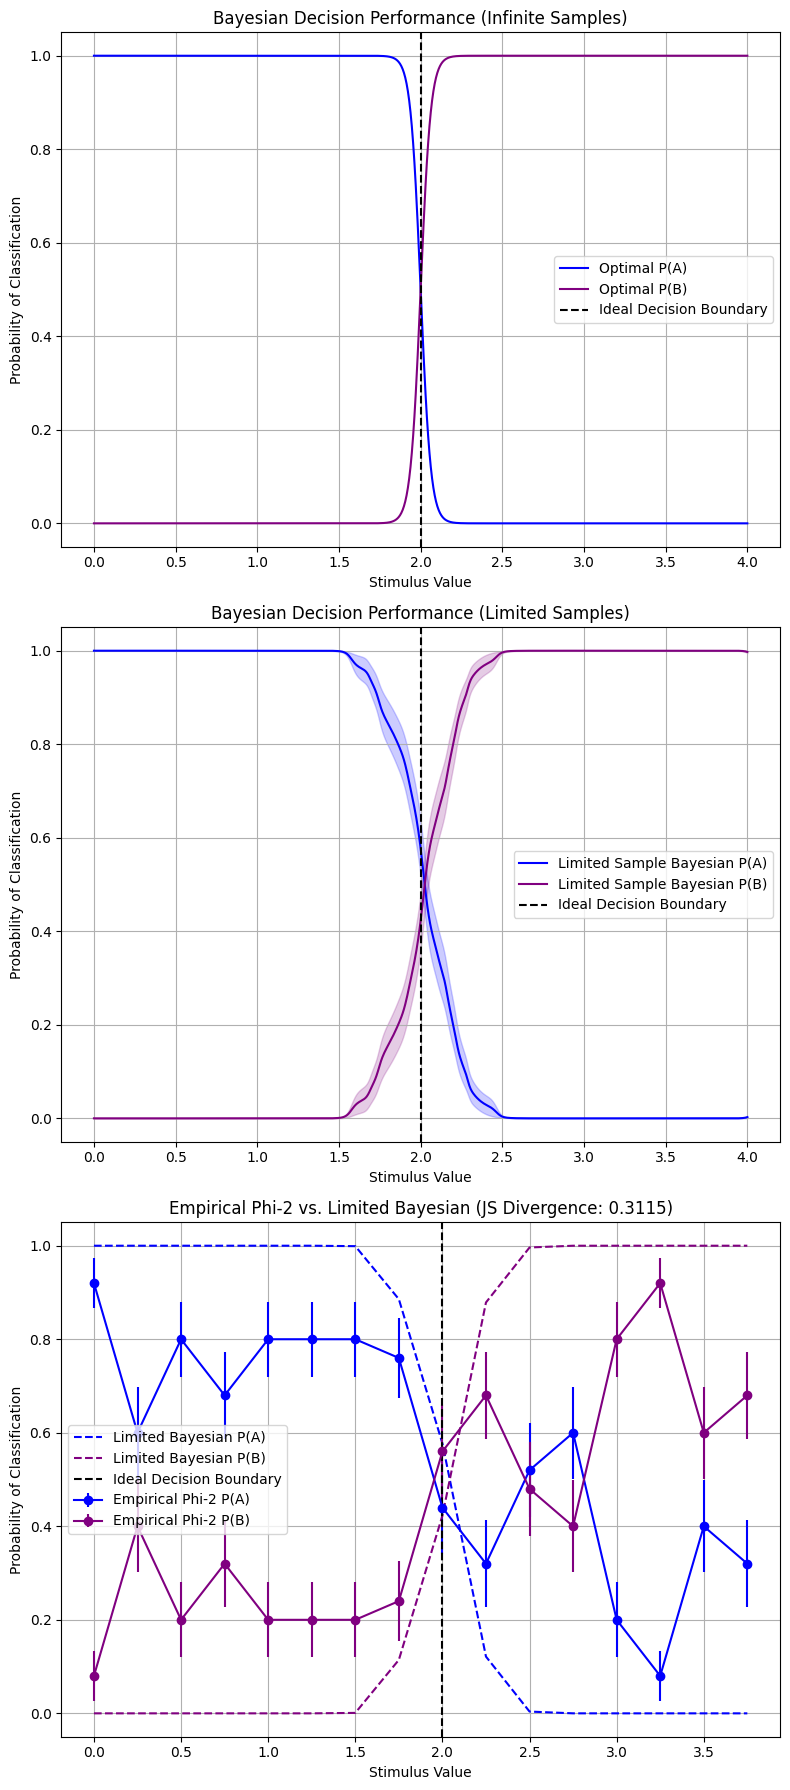

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import jensenshannon
from scipy.interpolate import interp1d

# Define stimulus values
x_values = np.linspace(0, 4, 1000)

# Compute Gaussian likelihoods for infinite-sample case
pdf_A = norm.pdf(x_values, dist_a['mean'], dist_a['std'])
pdf_B = norm.pdf(x_values, dist_b['mean'], dist_b['std'])

# Compute Bayesian optimal decision probability (infinite samples)
P_A_optimal = pdf_A / (pdf_A + pdf_B)  # P(A | x)
P_B_optimal = 1 - P_A_optimal  # P(B | x)

# Number of resampling iterations
num_resamples = 50

# Storage for resampled probabilities
P_A_limited_all = np.zeros((num_resamples, len(x_values)))
P_B_limited_all = np.zeros((num_resamples, len(x_values)))

np.random.seed(42)  # For reproducibility

for i in range(num_resamples):
    # Simulate limited sampling by drawing small sample sets
    sampled_A = np.random.normal(dist_a['mean'], dist_a['std'], n_samples)
    sampled_B = np.random.normal(dist_b['mean'], dist_b['std'], n_samples)

    # Estimate empirical means and variances from limited samples
    mu_A_est = np.mean(sampled_A)
    mu_B_est = np.mean(sampled_B)
    sigma_A_est = np.std(sampled_A, ddof=1)
    sigma_B_est = np.std(sampled_B, ddof=1)

    # Compute Gaussian likelihoods for limited-sample case
    pdf_A_limited = norm.pdf(x_values, mu_A_est, sigma_A_est)
    pdf_B_limited = norm.pdf(x_values, mu_B_est, sigma_B_est)

    # Compute Bayesian decision probabilities with limited sampling
    P_A_limited_all[i, :] = pdf_A_limited / (pdf_A_limited + pdf_B_limited)
    P_B_limited_all[i, :] = 1 - P_A_limited_all[i, :]

# Compute mean and standard error over resampling
P_A_limited_mean = np.mean(P_A_limited_all, axis=0)
P_B_limited_mean = np.mean(P_B_limited_all, axis=0)
P_A_limited_se = np.std(P_A_limited_all, axis=0, ddof=1) / np.sqrt(num_resamples)
P_B_limited_se = np.std(P_B_limited_all, axis=0, ddof=1) / np.sqrt(num_resamples)

# Interpolate Bayesian limited decision probabilities at empirical test points
interp_P_A_limited = interp1d(x_values, P_A_limited_mean, kind='linear', fill_value='extrapolate')
interp_P_B_limited = interp1d(x_values, P_B_limited_mean, kind='linear', fill_value='extrapolate')
P_A_limited_at_test = interp_P_A_limited(testing_samples_vector)
P_B_limited_at_test = interp_P_B_limited(testing_samples_vector)

# Compute JS divergence between empirical Phi-2 results and interpolated Bayesian classifier
js_div_A = jensenshannon(response_fractions_matrix[:, 0], P_A_limited_at_test)
js_div_B = jensenshannon(response_fractions_matrix[:, 1], P_B_limited_at_test)
js_div_total = (js_div_A + js_div_B) / 2

# Create figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Plot infinite-sample Bayesian decision performance
axes[0].plot(x_values, P_A_optimal, label='Optimal P(A)', color='blue', linestyle='solid')
axes[0].plot(x_values, P_B_optimal, label='Optimal P(B)', color='purple', linestyle='solid')
axes[0].axvline(x=ideal_decision_boundary, color='black', linestyle='dashed', label="Ideal Decision Boundary")
axes[0].set_xlabel('Stimulus Value')
axes[0].set_ylabel('Probability of Classification')
axes[0].set_title('Bayesian Decision Performance (Infinite Samples)')
axes[0].legend()
axes[0].grid(True)

# Plot limited-sample Bayesian decision performance with error bands
axes[1].plot(x_values, P_A_limited_mean, label='Limited Sample Bayesian P(A)', color='blue', linestyle='solid')
axes[1].fill_between(x_values, P_A_limited_mean - P_A_limited_se, P_A_limited_mean + P_A_limited_se, color='blue', alpha=0.2)
axes[1].plot(x_values, P_B_limited_mean, label='Limited Sample Bayesian P(B)', color='purple', linestyle='solid')
axes[1].fill_between(x_values, P_B_limited_mean - P_B_limited_se, P_B_limited_mean + P_B_limited_se, color='purple', alpha=0.2)
axes[1].axvline(x=ideal_decision_boundary, color='black', linestyle='dashed', label="Ideal Decision Boundary")
axes[1].set_xlabel('Stimulus Value')
axes[1].set_ylabel('Probability of Classification')
axes[1].set_title('Bayesian Decision Performance (Limited Samples)')
axes[1].legend()
axes[1].grid(True)

# Plot comparison between empirical Phi-2 results and interpolated limited Bayesian classifier
axes[2].errorbar(testing_samples_vector, response_fractions_matrix[:, 0], yerr=stderr_A, fmt='-o', color='blue', label='Empirical Phi-2 P(A)')
axes[2].plot(testing_samples_vector, P_A_limited_at_test, label='Limited Bayesian P(A)', color='blue', linestyle='dashed')
axes[2].errorbar(testing_samples_vector, response_fractions_matrix[:, 1], yerr=stderr_B, fmt='-o', color='purple', label='Empirical Phi-2 P(B)')
axes[2].plot(testing_samples_vector, P_B_limited_at_test, label='Limited Bayesian P(B)', color='purple', linestyle='dashed')
axes[2].axvline(x=ideal_decision_boundary, color='black', linestyle='dashed', label="Ideal Decision Boundary")
axes[2].set_xlabel('Stimulus Value')
axes[2].set_ylabel('Probability of Classification')
axes[2].set_title(f'Empirical Phi-2 vs. Limited Bayesian (JS Divergence: {js_div_total:.4f})')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()